I- PREPROCESSING

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

import sklearn.linear_model as s_lm
import sklearn.feature_selection as s_fs
import sklearn.preprocessing as s_pp
regres = s_lm.LinearRegression()
scaler = s_pp.StandardScaler()

pd.set_option('display.max_columns', None)

In [2]:
lmax=2600
lmin=1400

def adj_r2(r2,n,p):
    return 1-(1-r2)*(n-1)/(n-p-1)

def tabela(base,lista, lim_min, lim_max):
    no_MODELO = base.copy()
    no_MODELO = no_MODELO.drop(columns=['MODELO']).reset_index(drop=True)
    dataAux = no_MODELO.drop(columns=lista)
    dummysAux = pd.get_dummies(dataAux, drop_first=True)

    #STANDARDZATION
    precoAux = dummysAux['PREÇO DE CALCULO'].copy()
    varIndAux = dummysAux.drop(columns=['PREÇO DE CALCULO']).copy()

    scaler.fit(varIndAux)
    scaledAux = scaler.transform(varIndAux)

    #REGRESSAO
    regres.fit(scaledAux,precoAux)

    DELT = pd.DataFrame()
    DELT = regres.predict(scaledAux) - precoAux
    previAux = pd.DataFrame()
    auxData_4 = base.reset_index(drop=True)
    previAux['MODELO'] = auxData_4['MODELO']

    previAux['PREVISAO'] = regres.predict(scaledAux)
    previAux['PREÇO MERCADO'] = precoAux
    previAux['PREVISAO-PREÇO'] = DELT
    previAux['(PREVISAO-PREÇO)%'] = np.abs(DELT/precoAux)


    #R² e adjR²
    r2Aux = regres.score(scaledAux,precoAux)
    nAux = len(precoAux.index)
    pAux = len(varIndAux.columns)

    adjR2Aux = adj_r2(r2Aux,nAux,pAux)


    #VARIAVEIS E SUAS INFLUENCIAS
    varAux = pd.DataFrame(data=scaledAux,columns=varIndAux.columns.values)
    descVarAux = varAux.describe(include='all')

    p_valuesAux = s_fs.f_regression(scaledAux,precoAux)[1]

    descVarAux.loc['COEFICIENTES'] = regres.coef_
    descVarAux.loc['RELEVANCIA'] = p_valuesAux



    #PRINTS
    print(f'Numero de observações: {nAux}\nNumero de predicadores: {pAux}\nO valor de R²: {r2Aux}\nO valor de adjusR²:{adjR2Aux}')
    print('\n\nTabela dos coeficientes e suas relevancias:\n')
    print(descVarAux.loc[['COEFICIENTES','RELEVANCIA']].round(3))
    print('\n')
    print(f'\n\nTabela descritiva:\n{previAux.describe()}')

    #DEBUG TODOS OS PREDICATORIOS
    '''for i in descVarAux.columns:
        print(i)
        print(descVarAux[i].loc[['COEFICIENTES','RELEVANCIA']].round(3))
        print('\n')'''

    #PLOT
    x=[700,3300]
    plt.scatter(previAux['PREVISAO'],previAux['PREÇO MERCADO'])
    plt.plot(x,x)
    plt.show()

    print('\n\nTabela sem limitações:\n')
    print(previAux.sort_values(by='PREVISAO-PREÇO').round(2))

    belowAux = previAux[previAux['PREÇO MERCADO']<lim_max]
    betweenAux = belowAux[belowAux['PREÇO MERCADO']>lim_min]
    print(f'\n\nLimite Maximo: R${lim_max}\nLimite Minimo: R${lim_min}\n\n')
    print(betweenAux.round(2).sort_values(by='PREVISAO-PREÇO'))
    
    previAux.sort_values(by='PREVISAO-PREÇO').round(2).to_csv("Previsao.csv")


II- IMPORT DATA AND ANALYSE

In [3]:
celRawData = pd.read_csv('celData.csv')
descRawData = celRawData.describe(include="all")
#print(descRawData)
#print(celRawData)

III- CLEAN DATA

0- Dividir o RAW em dois, a tabela das variaveis independentes(xi) e a tabela da variavel dependente(y=PREÇO DE CALCULO) 
1- Percebe-se que faltam alguns valores em DOWNLOAD, UPLOAD e ANGULO MAXIMO.
-DOWNLOAD E UPLOAD: perceba que são função relacionados com a conectividade 5G. Para completar os dados que estão faltando, fazemos uma média entre os que possuem 5G e colocamos a media nos valores faltantes. Faz-se o mesmo para os que não possuem 5G.
Vale ressaltar que há em DOWNLOADS dois valores extremos de 10000mbps que irão alterar a media e precisam ser retirados.
-ANGULO MÁXIMO: como não há nenhuma relação direta, tira-se a media para completar os valores faltantes
2- MODELO E MARCA: Perceba que modelo é muito variavel, de modo que não há sentido em coloca-lo no modelo. Marca deve ser verificado para caso ela tenha peso no preço.

In [4]:
#CRIAÇÃO DAS TABELAS A SEREM MANIPULADAS
auxData = celRawData

#TABELAS PARA AJUSTE
downData = auxData[['5G','DOWNLOAD']]
upData = auxData[['5G','UPLOAD']]
angData = auxData['Angulo Maximo']

down5G = downData.loc[downData['5G']==1]
down4G = downData.loc[downData['5G']==0]

up5G = upData.loc[upData['5G']==1]
up4G = upData.loc[upData['5G']==0]

#ACRESCIMO DA MEDIA
down5G.fillna(down5G.mean(), inplace=True)
down4G.fillna(down4G.mean(), inplace=True)
up5G.fillna(up5G.mean(), inplace=True)
up4G.fillna(up4G.mean(), inplace=True)
angData.fillna(angData.mean(), inplace=True)

for i in down5G.index:
    downData['DOWNLOAD'].loc[i]= down5G['DOWNLOAD'].loc[i]
for i in down4G.index:
    downData['DOWNLOAD'].loc[i]= down4G['DOWNLOAD'].loc[i]

for i in up5G.index:
    upData['UPLOAD'].loc[i]= up5G['UPLOAD'].loc[i]
for i in up4G.index:
    upData['UPLOAD'].loc[i]= up4G['UPLOAD'].loc[i]

#CORREÇÃO NA TABELA PRINCIPAL
auxData['DOWNLOAD'] = downData['DOWNLOAD']
auxData['UPLOAD'] = upData['UPLOAD']
auxData['Angulo Maximo'] = angData

#auxData.drop(columns=["MODELO"],inplace=True)
#print(auxData)

/tmp/ipykernel_5091/3963802914.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down5G.fillna(down5G.mean(), inplace=True)
/tmp/ipykernel_5091/3963802914.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down5G.fillna(down5G.mean(), inplace=True)
/tmp/ipykernel_5091/3963802914.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

IV- INICIO DA ANÁLISE

0- Remover valores extremos
1- Checkar visualmente pelo distplot variaveis pouco relacionadas e as retirar
2- Criar os dummies
3- Normalizar todas as variaveis do modelo
4- Criacao da REGRESSAO

In [5]:
#REMOVENDO OS VALORES EXTREMOS DE DOWNLOAD
Q = auxData['DOWNLOAD'].quantile(.99)
auxData_1 = auxData[auxData['DOWNLOAD']<Q]

#REMOVENDO OS VALORES MINIMOS DE RAM
Q = auxData_1['RAM'].quantile(.01)
auxData_2 = auxData_1[auxData_1['RAM']>Q]

#REMOVER VARIAVEIS INUTEIS
#RETIRAR: ,'Ver','Angulo Maximo','BATERIA','Expansivo','Bússola'
#RETIRAR:,'MARCA','TELA','5G','UPLOAD'
#RETIRAR:,'RAM', 'Freq. Atual.','Giroscópio'
cleanData = auxData_2.drop(columns=['MODELO']).reset_index(drop=True)


#DUMMIES
cleanDummys = pd.get_dummies(cleanData, drop_first=True)


V- COMPLETO

Numero de observações: 57
Numero de predicadores: 26
O valor de R²: 0.884481010658547
O valor de adjusR²:0.7843645532292878


Tabela dos coeficientes e suas relevancias:

                  RAM     HDD  Expansivo  Freq. Core       5G  DOWNLOAD  \
COEFICIENTES  287.503 -70.900   -256.534     -10.672  124.402     3.009   
RELEVANCIA      0.000   0.001      0.000       0.000    0.000     0.000   

              UPLOAD      Ver  Princ.    Front  Angulo Maximo  Giroscópio  \
COEFICIENTES  64.627  130.178  43.548  164.698        -21.184      112.73   
RELEVANCIA     0.001    0.000   0.001    0.000          0.001        0.00   

              Bússola  BATERIA  MARCA_BLACKVIEW  MARCA_DOOGEE  MARCA_MOTOROLA  \
COEFICIENTES  -88.969   -2.100           41.543       179.903          29.117   
RELEVANCIA      0.017    0.428            0.976         0.058           0.032   

              MARCA_OPPO  MARCA_POCO  MARCA_REALME  MARCA_SAMSUNG  \
COEFICIENTES     300.407      96.761        29.930        

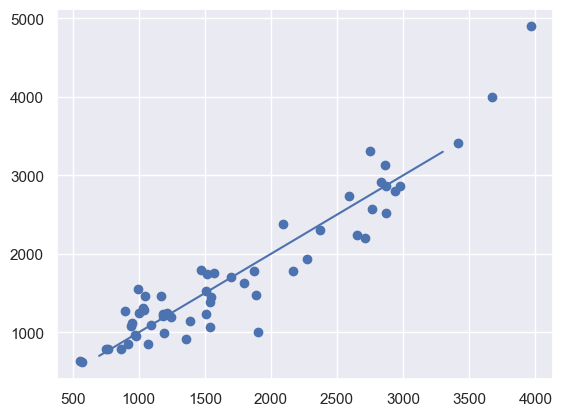



Tabela sem limitações:

                  MODELO  PREVISAO  PREÇO MERCADO  PREVISAO-PREÇO  \
26            Reno 6 PRO   3964.43        4902.02         -937.59   
53            Xiaomi 12t   2750.39        3311.50         -561.11   
15         Galaxy A24 4G    993.99        1554.00         -560.01   
30             Poco  C55   1046.47        1459.00         -412.53   
47              RedMi 12    895.33        1271.70         -376.37   
28            Reno 8 PRO   3670.07        4001.81         -331.74   
51  RedMi Note 12 PRO 4G   1467.46        1789.33         -321.87   
16            Galaxy A31   1168.19        1469.00         -300.81   
42             RealMe 9I   1031.70        1315.00         -283.30   
19            Galaxy A53   2090.94        2374.00         -283.06   
33            Poco X4 GT   2863.20        3137.67         -274.47   
46     RedMi 11 PRIME 5G   1037.16        1284.00         -246.84   
31               Poco M3   1004.54        1242.00         -237.46   
25      

In [6]:
tabela(auxData_2,[],lmin,lmax)

VI- MODELO ESCOLHIDO

Numero de observações: 57
Numero de predicadores: 11
O valor de R²: 0.811939694452774
O valor de adjusR²:0.7659693975412298


Tabela dos coeficientes e suas relevancias:

                 RAM      HDD  Expansivo  Freq. Core  UPLOAD      Ver  \
COEFICIENTES  373.28 -141.991   -300.179      12.287  46.449  168.921   
RELEVANCIA      0.00    0.001      0.000       0.000   0.001    0.000   

                Front  TELA_IPS  TELA_OLED  TELA_PLS  TELA_TFT  
COEFICIENTES  338.332    96.256     34.159    44.768    -7.595  
RELEVANCIA      0.000     0.001      0.416     0.220     0.481  




Tabela descritiva:
          PREVISAO  PREÇO MERCADO  PREVISAO-PREÇO  (PREVISAO-PREÇO)%
count    57.000000      57.000000    5.700000e+01       5.700000e+01
mean   1727.588728    1727.588728   -3.590111e-14       1.876254e-01
std     811.785512     900.905855    3.906861e+02       1.685964e-01
min     557.599018     622.000000   -1.275296e+03       6.254166e-16
25%    1115.621050    1090.666667   -1.683790e

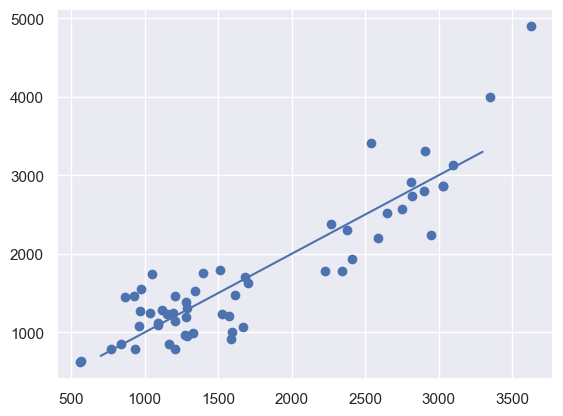



Tabela sem limitações:

                  MODELO  PREVISAO  PREÇO MERCADO  PREVISAO-PREÇO  \
26            Reno 6 PRO   3626.72        4902.02        -1275.30   
55            Doogee V30   2538.40        3417.00         -878.60   
25                   A77   1050.26        1749.14         -698.89   
28            Reno 8 PRO   3352.59        4001.81         -649.22   
24                   A57    866.04        1453.98         -587.94   
15         Galaxy A24 4G    975.05        1554.00         -578.95   
30             Poco  C55    927.22        1459.00         -531.78   
53            Xiaomi 12t   2908.32        3311.50         -403.18   
10            Galaxy M23   1394.64        1759.50         -364.86   
47              RedMi 12    970.74        1271.70         -300.95   
51  RedMi Note 12 PRO 4G   1510.54        1789.33         -278.80   
16            Galaxy A31   1208.70        1469.00         -260.30   
6               Moto G53   1038.70        1244.78         -206.08   
18      

In [7]:
excluir = ['BATERIA','Bússola','Angulo Maximo','Princ.','DOWNLOAD','Giroscópio','5G','MARCA']#, 'MARCA','Ver','Expansivo',,'UPLOAD']
tabela(auxData_2,excluir,lmin,lmax)

EXTRA: APENAS 5G

In [8]:
excluir2 = excluir
excluir2.append('5G')
print(excluir2)

['BATERIA', 'Bússola', 'Angulo Maximo', 'Princ.', 'DOWNLOAD', 'Giroscópio', '5G', 'MARCA', '5G']


auxData_3 = auxData_2.loc[auxData_2['5G']==1]
tabela(auxData_3,excluir2,lmin,lmax)

EXTRA: APENAS 4G

auxData_4 = auxData_2.loc[auxData_2['5G']==0]
tabela(auxData_4,excluir2,lmin,lmax)